In [0]:
import glob
import yaml
import cv2
import numpy as np
import os
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as im 
import pandas as pd
import seaborn as sns
from skimage.transform import rescale, resize
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread, imshow
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import itertools 
from skimage.color import rgb2gray
from skimage import data, feature

In [0]:
def image_path(img_type, img_number):
    #image_type: 'images' #original image, 'annotations' #crop-weed label, 'mask' #vegetation segmentation
    #image_number: the number on the image name
    image_name = img_type[:-1]
    if img_number < 10:
        path = '/content/'+img_type+'/00'+str(img_number)+'_'+str(image_name)+'.png'
    else:
        path = '/content/'+img_type+'/0'+str(img_number)+'_'+str(image_name)+'.png'
    return path

# generating labels for each image
def label_generator(number):
    annotation = cv2.imread(image_path('annotations', number))
    height = annotation.shape[0]
    width = annotation.shape[1]
   # channel = annotation.shape[2]
    labels = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            if np.all(annotation[i,j,:] == np.array([0,255,0])):
                labels[i,j,0] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,255])):
                labels[i,j,1] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,0])):
                labels[i,j,2] = 1
    return labels

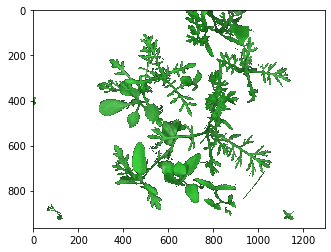

In [0]:
# Load two images
img1 = cv2.imread(image_path('images',1))
img2 = cv2.imread(image_path('masks',1))

# I want to put logo on top-left corner, So I create a ROI
rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols ]

# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

# Put logo in ROI and modify the main image
dst = cv2.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst
plt.imshow(img1)

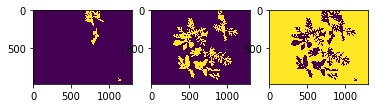

In [0]:
label = label_generator(1)
plt.figure()

#plt.imshow(label)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(label[:,:,i])

(72576,)
(72576,)


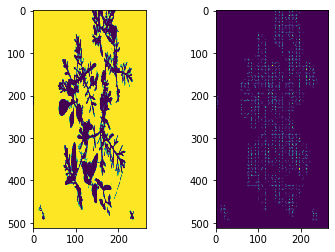

In [0]:
img = imread(image_path('masks',1))
mm = resize(img,(512,265))
fd, hog_image = hog(mm, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=None)
plt.subplot(1,2,1)
plt.imshow(mm)
plt.subplot(1,2,2)
plt.imshow(hog_image)
print(fd.shape)
td = fd.ravel()  
print(td.shape)

(3780,)
(3780,)


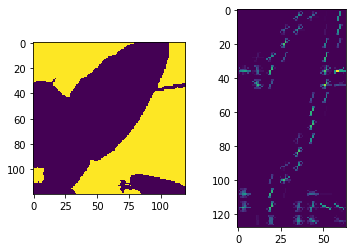

In [0]:
img = imread(image_path('masks',1))
mm = resize(img[640:760,640:760],(128,64))
fd, hog_image = hog(mm, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=None)
plt.subplot(1,2,1)
plt.imshow(img[640:760,640:760])
plt.subplot(1,2,2)
plt.imshow(hog_image)
print(fd.shape)
td = fd.ravel()  
print(td.shape)

In [0]:
img = imread(image_path('masks',1))
width, height = img.shape[:2]
print(width, height )

966 1296


In [0]:
levels=[]
train_labels=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_labels:
  label=label_generator(i)
  level=np.sum(label[:,:,1])/(np.sum(label[:,:,1])+np.sum(label[:,:,0]))
  levels.append(level)

In [0]:
y = np.empty((60,width,height,3))
for i in range(1,61):
  y[i-1]=cv2.imread(image_path("annotations",i))

y/=255

Y = np.sum(y,(1,2))[:,-1]/np.sum(y,(1,2,3))
print(Y)

[0.85018318 0.89648562 0.74497219 0.91418    0.78998694 0.59147286
 0.78120693 0.86539207 0.73976874 0.8104898  0.69709057 0.81656668
 0.70762017 0.90237864 0.73815525 0.87172563 0.67062324 0.80120554
 0.66972253 0.24505545 0.29128998 0.59902801 0.91508527 0.96300194
 0.57552427 0.95532635 0.62954107 0.85019663 0.98174603 0.46778094
 0.8374772  0.76941356 0.8012647  0.94021673 0.39274487 0.91904945
 0.34394622 0.88344169 0.63020408 0.89373432 0.70942404 0.74180848
 0.60717502 0.55579941 0.73736463 0.8001054  0.76180845 0.77259433
 0.22463347 0.         0.79686124 0.72899571 0.77520693 0.67039001
 0.52909933 0.84453439 0.98286563 0.82842125 0.89097199 0.80394291]


In [0]:
levels=[]
for i,level in enumerate(Y):
  if level < 0.75 :
    levels.append(1)
  elif (level>=0.75)&(level<1.0):
    levels.append(2)
print(levels)
print(len(levels))

[2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2]
60


In [0]:
img_feature_train = []

train_data=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_data:
  img_mask = imread(image_path('masks',i))
  image_resized = resize(img_mask,(512,1024))
  descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
  img_feature_train.append(descriptor)
print("younis & menna & Omar")

younis & menna & Omar


In [0]:
Y_train = [levels[i-1] for i in train_data]


In [0]:
img_feature_test = []

test_data=[1, 3, 4, 9, 10, 13, 15, 21, 22, 26, 29, 30, 32, 35, 39, 44, 47, 48, 54, 60]
for i in test_data:
  img_mask = imread(image_path('masks',i))
  image_resized = resize(img_mask,(512,1024))
  descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
  img_feature_test.append(descriptor)
print("younis & menna & Omar")

younis & menna & Omar


In [0]:
Y_test = [levels[i-1] for i in test_data]

In [0]:
clf = svm.SVC(class_weight='balanced')
features_train = np.array(img_feature_train)
features_test = np.array(img_feature_test)
labels_test = np.array(Y_test)
labels_train = np.array(Y_train)

In [0]:
clf.fit(features_train,labels_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
labels_pred = clf.predict(features_test)


In [0]:
print('MSE: ' , mean_squared_error(labels_test, labels_pred))

MSE:  0.45


In [0]:
print(classification_report(labels_test, labels_pred))


              precision    recall  f1-score   support

           1       0.62      0.45      0.53        11
           2       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



In [0]:
blob_feature_train = []

train_data=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_data:
  #img_mask = imread(image_path('masks',i))
  img_mask = cv2.imread(image_path('masks',i))
  #img_gary = rgb2gray(img_mask)
  gray= cv2.cvtColor(img_mask,cv2.COLOR_BGR2GRAY)
  #dst = cv2.cornerHarris(img_gary,3,3,0.04)
  #img_gary = cv2.cvtColor(img_mask,cv2.COLOR_BGR2GRAY)
  #desc= feature.blob_dog(img_gary, threshold=.5, max_sigma=40)
  surf = cv2.SURF()
  kps, desc =surf.detectAndCompute(img_mask,None)
  blob_feature_train.append(desc.flatten())
print("younis & menna & Omar")

AttributeError: ignored

In [0]:

cv2.__version__

'4.1.2'

In [0]:
dst

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
blob_feature_test = []

test_data=[1, 3, 4, 9, 10, 13, 15, 21, 22, 26, 29, 30, 32, 35, 39, 44, 47, 48, 54, 60]
for i in test_data:
  img_mask = imread(image_path('masks',i))
  img_gary = rgb2gray(img_mask)
  sift = cv2.xfeatures2d.SIFT_create()
  kp, desc = sift.detectAndCompute(img_gary,None)
  
  #desc= feature.blob_dog(img_gary, threshold=.5, max_sigma=40)
  #dst = cv2.cornerHarris(img_gary,3,3,0.04)
  blob_feature_test.append(desc.flatten())
print("younis & menna & Omar")

younis & menna & Omar


In [0]:
clf = svm.SVC(class_weight='balanced')
features_train = np.array(blob_feature_train)
features_test = np.array(blob_feature_test)
labels_test = np.array(Y_test)
labels_train = np.array(Y_train)

In [0]:
clf.fit(blob_feature_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
labels_pred = clf.predict(features_test)


In [0]:
print('MSE: ' , mean_squared_error(labels_test, labels_pred))

MSE:  0.55


In [0]:
print(classification_report(labels_test, labels_pred))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.45      1.00      0.62         9

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:

perc={}
globbing = glob.glob("annotations /*.png")
for f in globbing:
  num = int(f[13:16])
  img_ann = im.open(f)
  img_ann_arr = np.array(img_ann)
  width, height = img_ann_arr.shape[:2]
  g_count = 0 
  r_count = 0 
  for i in range(width):
    for j in range(height):
      if np.all(img_ann_arr[i][j] == np.array([0, 255, 0])):
        g_count+=1
      if np.all(img_ann_arr[i][j] == np.array([255, 0, 0])):
        r_count+=1
  level = r_count/(g_count+r_count)

  perc[num]=level    

In [0]:
perc

{1: 0.8501831752997414,
 2: 0.896485617856251,
 3: 0.7449721865639709,
 4: 0.9141800048258667,
 5: 0.7899869430390076,
 6: 0.5914728597009679,
 7: 0.7812069278685372,
 8: 0.8653920723825937,
 9: 0.7397687425096542,
 10: 0.8104898032414329,
 11: 0.6970905678085406,
 12: 0.8165666820489156,
 13: 0.7076201690567308,
 14: 0.9023786381058925,
 15: 0.7381552461983457,
 16: 0.8717256304102371,
 17: 0.6706232403378551,
 18: 0.8012055430951618,
 19: 0.6697225250884493,
 20: 0.2450554528650647,
 21: 0.29128998293577313,
 22: 0.5990280136409449,
 23: 0.915085272082019,
 24: 0.9630019385211853,
 25: 0.5755242731881597,
 26: 0.955326345400355,
 27: 0.6295410721172388,
 28: 0.8501966311290946,
 29: 0.9817460317460317,
 30: 0.4677809388335704,
 31: 0.8374772021136254,
 32: 0.7694135596787205,
 33: 0.8012647006678092,
 34: 0.9402167277167277,
 35: 0.3927448660975948,
 36: 0.9190494520259426,
 37: 0.34394621818907944,
 38: 0.8834416942321585,
 39: 0.6302040816326531,
 40: 0.8937343222096082,
 41: 0.709

In [0]:
df=pd.DataFrame.from_dict(perc,orient='index')

In [0]:
df.shape
df.head()

,0,Category_1,Category_2,Category_3,Category_4
54,0.670390,0.0,1.0,0.0,0.0
36,0.919049,0.0,0.0,0.0,1.0
40,0.893734,0.0,0.0,0.0,1.0
9,0.739769,0.0,0.0,1.0,0.0
38,0.883442,0.0,0.0,0.0,1.0


In [0]:
df.loc[df[0]<0.4,'Category_1']=1


In [0]:
df.loc[(df[0]>=0.4)&(df[0]<0.7),'Category_2']=1


In [0]:
df=df.fillna(0)

In [0]:
df.loc[(df[0]>=0.7)&(df[0]<0.85),'Category_3']=1
df.loc[df[0]>=0.85,'Category_4']=1

In [0]:
img_try = im.open('/content/annotations /001_annotation.png')

img_try = np.array(img_try)

In [0]:
from scipy import misc

In [0]:
misc.imread

In [0]:
img_try_rav = img_try.ravel()
img_try_ff = img_try.flatten().reshape(1,1251936)

ValueError: ignored

In [0]:
img_try_rav.shape
print(img_try_ff.shape)

(3755808,)


In [0]:
g_count = 0 
r_count = 0 
for i in range(width):
  for j in range(height):
    if np.all(img_ann_arr[i][j] == np.array([0, 255, 0])):
      g_count+=1
    if np.all(img_ann_arr[i][j] == np.array([255, 0, 0])):
      r_count+=1
print(g_count)
print(r_count)

30589
173587


In [0]:
for i in perc

In [0]:
level = g_count/(g_count+r_count)
print(level)

0.1498168247002586


In [0]:
img_ann = im.open('001_annotation.png')
img_mask = im.open("001_annotation.png")

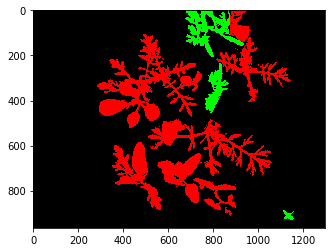

In [0]:
plt.imshow(img_ann)

In [0]:
img_ann_arr = np.array(img_ann)
img_mask_arr = np.array(img_mask)

In [0]:
img_ann_arr.shape

(966, 1296, 3)

In [0]:
width, height = img_ann_arr.shape[:2]

In [0]:
for i in range (height-80,step= 80):
  for j in range (width-80,step=80):
